# README
- Simply run each of the code blocks in order to view the intended results

# Linear Regression Analysis Project Auto MPG Data Set

- Data loading from **UCI ML Repository** using `ucimlrepo` [link](https://archive.ics.uci.edu/dataset/9/auto+mpg)
- Two regression models:
  1. **SGDRegressor** (with hyperparameter tuning via `RandomizedSearchCV`)
  2. **OLS** via `statsmodels` (with full summary + interpretation prompts)

## Authors: Xinlong Hu (XXH210007), Daniel Hartojo (DCH180005)


In [ ]:
pip install ucimlrepo statsmodels scikit-learn pandas numpy matplotlib


In [ ]:

from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.width", 120)
pd.set_option("display.max_columns", None)


# 1) Dataset Selection

In [ ]:
# Fetch Auto MPG dataset (UCI ML Repo ID=9) (https://archive.ics.uci.edu/dataset/9/auto+mpg)
auto_mpg = fetch_ucirepo(id=9)

# Features (X) and target (y)
X = auto_mpg.data.features.copy()
y = auto_mpg.data.targets.copy()

# Make a data frame
df = auto_mpg.data.original
print("\nOriginal df head:")
display(df.head())


Original df head:


,car_name,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg
0,"chevrolet,chevelle,malibu",8,307.0,130.0,3504,12.0,70,1,18.0
1,"buick,skylark,320",8,350.0,165.0,3693,11.5,70,1,15.0
2,"plymouth,satellite",8,318.0,150.0,3436,11.0,70,1,18.0
3,"amc,rebel,sst",8,304.0,150.0,3433,12.0,70,1,16.0
4,"ford,torino",8,302.0,140.0,3449,10.5,70,1,17.0


In [ ]:
# Add descriptions manually
metadata = auto_mpg.variables.copy()

descriptions = {
    "mpg": "Miles per gallon (target)",
    "cylinders": "Number of cylinders",
    "displacement": "Engine displacement (cubic inches)",
    "horsepower": "Engine horsepower (some missing values)",
    "weight": "Vehicle weight (lbs)",
    "acceleration": "Acceleration time (seconds to reach 60 mph)",
    "model_year": "Model year",
    "origin": "Car origin (1=USA, 2=Europe, 3=Japan)",
    "car_name": "Car name (string identifier)"
}

# Map into metadata dataframe
metadata["description"] = metadata["name"].map(descriptions)

# Variable metadata
print("Variables metadata:")
print(metadata)

Variables metadata:
           name     role         type demographic                                  description units missing_values
0  displacement  Feature   Continuous        None           Engine displacement (cubic inches)  None             no
1           mpg   Target   Continuous        None                    Miles per gallon (target)  None             no
2     cylinders  Feature      Integer        None                          Number of cylinders  None             no
3    horsepower  Feature   Continuous        None      Engine horsepower (some missing values)  None            yes
4        weight  Feature   Continuous        None                         Vehicle weight (lbs)  None             no
5  acceleration  Feature   Continuous        None  Acceleration time (seconds to reach 60 mph)  None             no
6    model_year  Feature      Integer        None                                   Model year  None             no
7        origin  Feature      Integer        None   

In [ ]:
# Check basic info & null counts
print("\nNull counts in combined df:")
print(df.isna().sum())


Null counts in combined df:
car_name        0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
mpg             0
dtype: int64


# 2) Regression Model Building

## 2.1) Preprocessing

In [ ]:
# Clean up data set
df_clean = df.dropna().copy()

print("\nCleaned df (dropna) head:")
display(df_clean.head())


Cleaned df (dropna) head:


,car_name,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg
0,"chevrolet,chevelle,malibu",8,307.0,130.0,3504,12.0,70,1,18.0
1,"buick,skylark,320",8,350.0,165.0,3693,11.5,70,1,15.0
2,"plymouth,satellite",8,318.0,150.0,3436,11.0,70,1,18.0
3,"amc,rebel,sst",8,304.0,150.0,3433,12.0,70,1,16.0
4,"ford,torino",8,302.0,140.0,3449,10.5,70,1,17.0


In [ ]:
# Numeric summary
print("\nDescribe (numeric):")
display(df_clean.describe())


Describe (numeric):


,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531,23.445918
std,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518,7.805007
min,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000,9.000000
25%,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000,17.000000
50%,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000,22.750000
75%,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000,29.000000
max,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000,46.600000


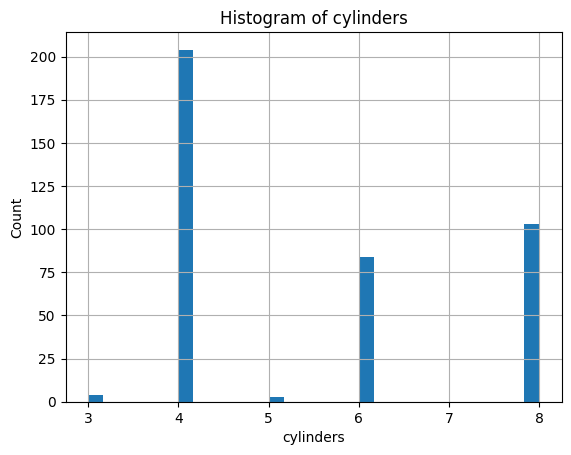

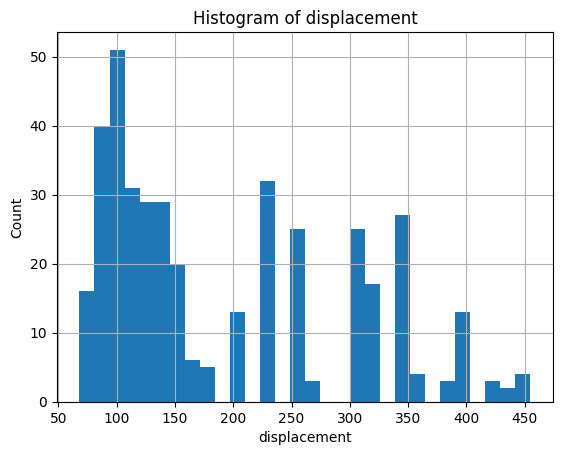

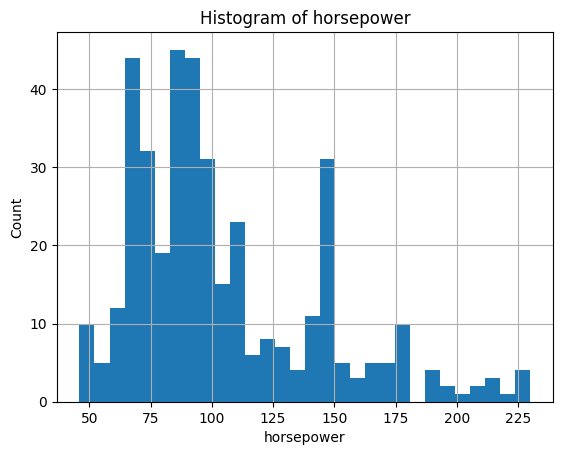

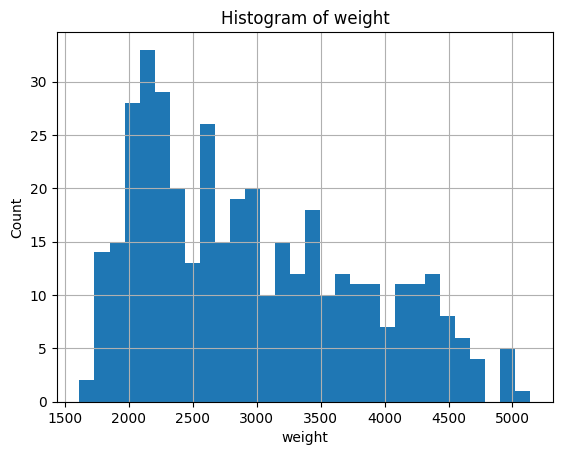

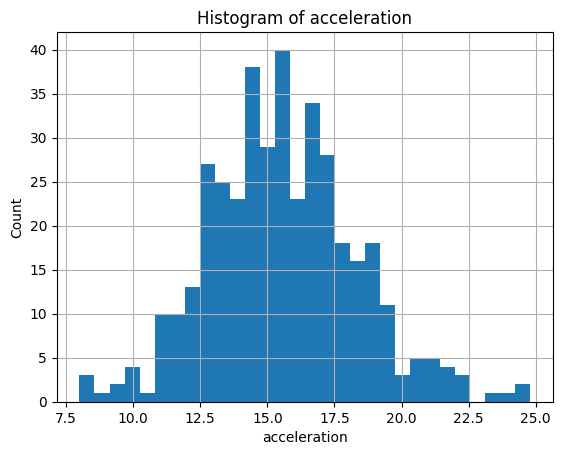

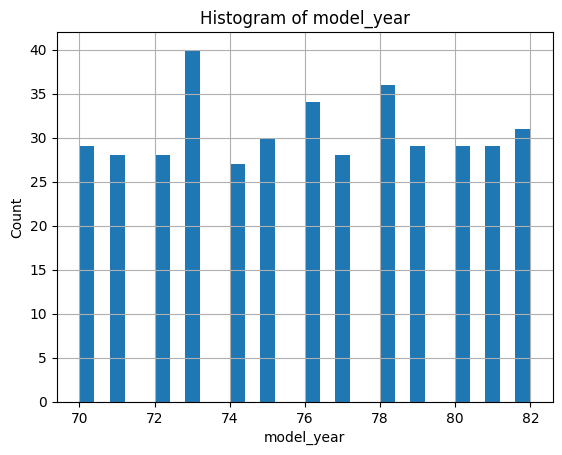

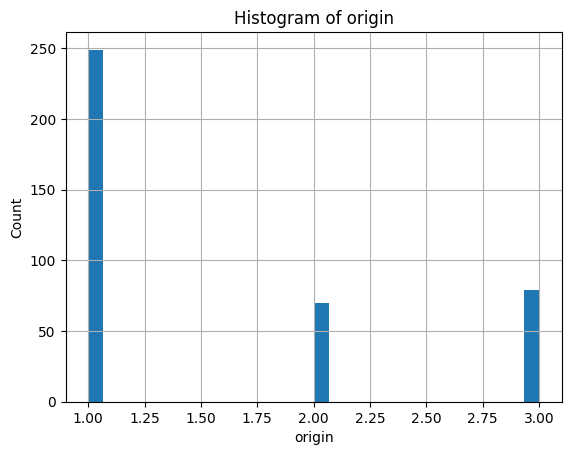

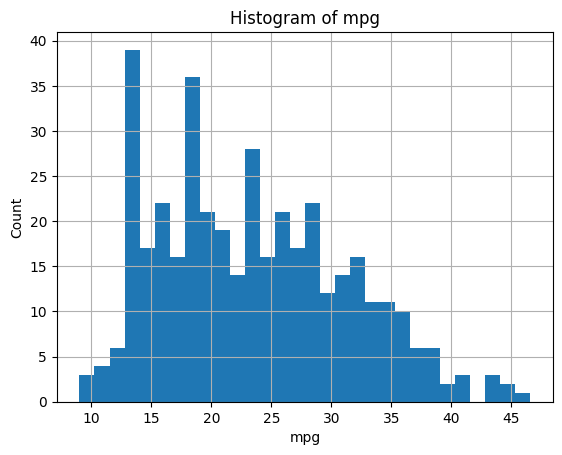

In [ ]:
# Histograms for numeric columns
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols:
    plt.figure()
    df[col].hist(bins=30)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

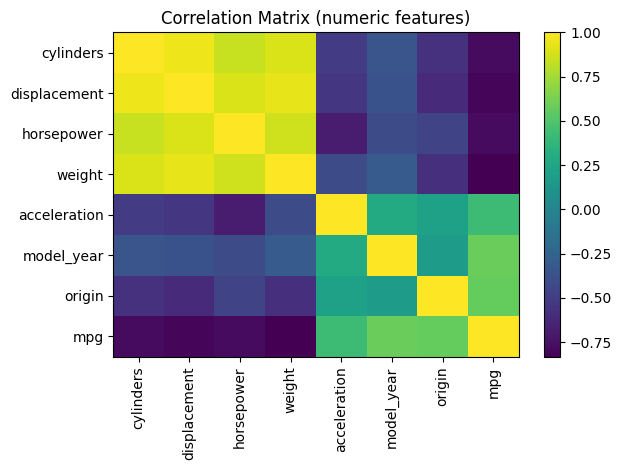

In [ ]:
# Correlation matrix + simple imshow heatmap (no seaborn, one plot)
corr = df_clean[numeric_cols].corr()
plt.figure()
plt.imshow(corr, cmap="viridis", aspect="auto")
plt.xticks(ticks=range(len(numeric_cols)), labels=numeric_cols, rotation=90)
plt.yticks(ticks=range(len(numeric_cols)), labels=numeric_cols)
plt.title("Correlation Matrix (numeric features)")
plt.colorbar()
plt.tight_layout()
plt.show()

In [ ]:
# Identify target column name
target_col = y.columns[0] if hasattr(y, "columns") else "mpg"
print("\nTarget column:", target_col)

# Choose a small set of important features based on correlation with target
corr_with_target = corr[target_col].drop(labels=[target_col], errors="ignore").sort_values(ascending=False)
print("\nCorrelation with target:")
display(corr_with_target)

top_k = 5

# Take absolute correlation values, sort descending
selected_features = (
    corr_with_target.abs()
    .sort_values(ascending=False)
    .head(top_k)
    .index
    .tolist()
)

print(f"\nTop {top_k} features by correlation with {target_col}:", selected_features)



Target column: mpg

Correlation with target:


,mpg
model_year,0.580541
origin,0.565209
acceleration,0.423329
cylinders,-0.777618
horsepower,-0.778427
displacement,-0.805127
weight,-0.832244



Top 5 features by correlation with mpg: ['weight', 'displacement', 'horsepower', 'cylinders', 'model_year']


## 2.2) Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# Copy cleaned data frame
model_df = df_clean.copy()

# Use selected features
candidate_X_cols = selected_features

X_model = model_df[candidate_X_cols]
y_model = model_df[target_col]

# Set training size to 80% and test size to 20%
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=42)
print("Train/Test sizes:", X_train.shape, X_test.shape)

Train/Test sizes: (313, 5) (79, 5)


## 2.3) Model 1: SGDRegressor (with Standardization + Hyperparameter Tuning)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best params: {'sgd__penalty': 'l2', 'sgd__max_iter': 1000, 'sgd__loss': 'squared_error', 'sgd__learning_rate': 'adaptive', 'sgd__l1_ratio': 0.5, 'sgd__eta0': 0.01, 'sgd__alpha': 1e-05}
Best CV R^2: 0.859864989750187

SGDRegressor with Polynomial Features Performance:
Train MAE=2.0355  MSE=8.0581  RMSE=2.8387  R^2=0.8723
Test MAE=2.0410  MSE=7.2486  RMSE=2.6923  R^2=0.8580


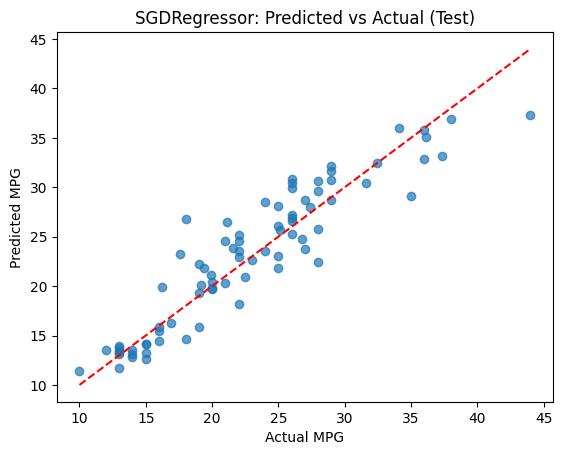

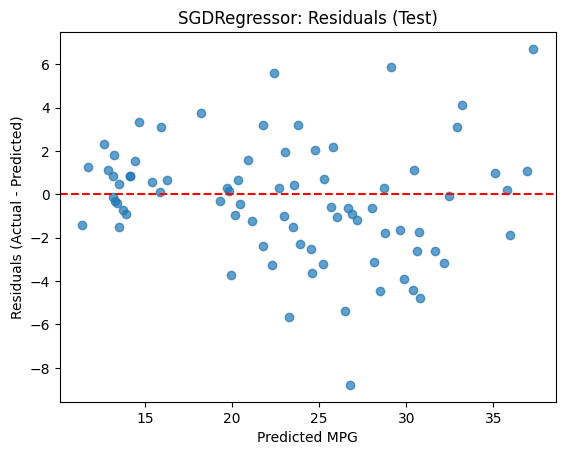

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Pipeline: PolynomialFeatures + Scaling + SGD
sgd_pipe = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
    ("scaler", StandardScaler()),
    ("sgd", SGDRegressor(random_state=42, early_stopping=True, tol=1e-4))
])

# Reduced, efficient hyperparameter grid
param_grid = {
    "sgd__loss": ["squared_error", "huber"],
    "sgd__penalty": ["l2", "elasticnet"],
    "sgd__alpha": [1e-5, 1e-4, 1e-3],
    "sgd__l1_ratio": [0.15, 0.5],
    "sgd__learning_rate": ["constant", "adaptive"],
    "sgd__eta0": [0.01, 0.1],
    "sgd__max_iter": [1000, 2000]
}

# Randomized search to speed up tuning
grid = RandomizedSearchCV(
    estimator=sgd_pipe,
    param_distributions=param_grid,
    n_iter=50,
    scoring="r2",
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit model
grid.fit(X_train, y_train)

# Best model
best_model = grid.best_estimator_
print("Best params:", grid.best_params_)
print("Best CV R^2:", grid.best_score_)

# Predictions
y_tr_pred = best_model.predict(X_train)
y_te_pred = best_model.predict(X_test)

# Evaluation function
def eval_and_print(y_true, y_pred, split_name=""):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{split_name} MAE={mae:.4f}  MSE={mse:.4f}  RMSE={rmse:.4f}  R^2={r2:.4f}")

# Evaluate
print("\nSGDRegressor with Polynomial Features Performance:")
eval_and_print(y_train, y_tr_pred, "Train")
eval_and_print(y_test, y_te_pred, "Test")

# Plot: Predicted vs Actual (Test)
plt.figure()
plt.scatter(y_test, y_te_pred, alpha=0.7)
plt.xlabel("Actual MPG")
plt.ylabel("Predicted MPG")
plt.title("SGDRegressor: Predicted vs Actual (Test)")

# Plot 45 degree line
lims = [min(y_test.min(), y_te_pred.min()), max(y_test.max(), y_te_pred.max())]
plt.plot(lims, lims, color="red", linestyle="--")
plt.show()

# Plot: Residuals
residuals = y_test - y_te_pred
plt.figure()
plt.scatter(y_te_pred, residuals, alpha=0.7)
plt.axhline(0, linestyle="--", color="red")
plt.xlabel("Predicted MPG")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("SGDRegressor: Residuals (Test)")
plt.show()

## 2.4) Model 2: OLS (statsmodels)

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     262.7
Date:                Sun, 21 Sep 2025   Prob (F-statistic):          1.33e-108
Time:                        23:23:03   Log-Likelihood:                -832.42
No. Observations:                 313   AIC:                             1677.
Df Residuals:                     307   BIC:                             1699.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -13.7669      5.021     -2.742   

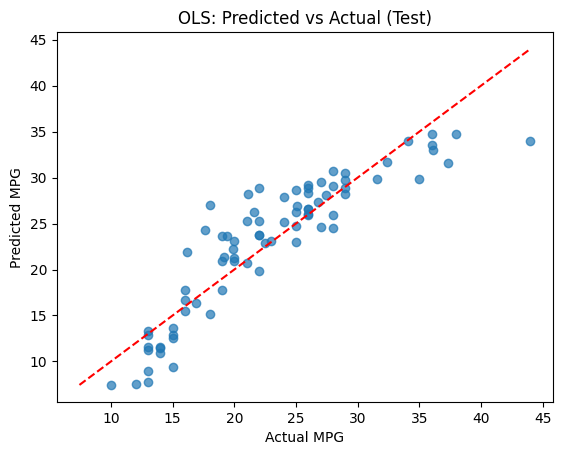

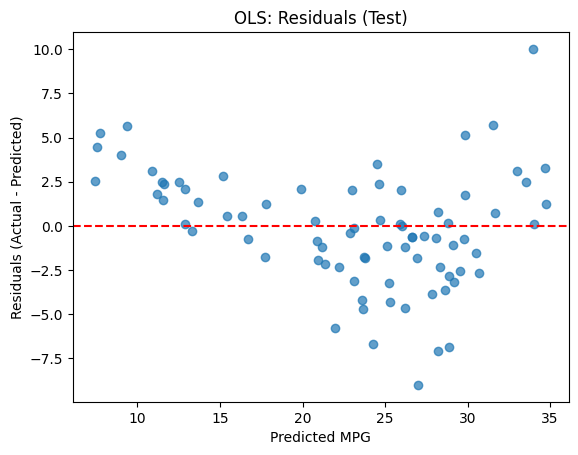

In [ ]:
# Fit OLS on TRAIN set
X_train_sm = sm.add_constant(X_train)  # add intercept
ols_model = sm.OLS(y_train, X_train_sm).fit()

print(ols_model.summary())

# Evaluate on test
X_test_sm = sm.add_constant(X_test, has_constant='add')
y_pred_ols = ols_model.predict(X_test_sm)

print("\nOLS Performance on Test:")
print("MAE:", mean_absolute_error(y_test, y_pred_ols))
print("MSE:", mean_squared_error(y_test, y_pred_ols))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ols)))
print("R^2:", r2_score(y_test, y_pred_ols))

# Plot: OLS Predicted vs Actual
plt.figure()
plt.scatter(y_test, y_pred_ols, alpha=0.7)
plt.xlabel("Actual MPG")
plt.ylabel("Predicted MPG")
plt.title("OLS: Predicted vs Actual (Test)")
lims = [min(y_test.min(), y_pred_ols.min()), max(y_test.max(), y_pred_ols.max())]
plt.plot(lims, lims, color="red", linestyle="--")
plt.show()

# Plot: OLS Residuals
residuals_ols = y_test - y_pred_ols
plt.figure()
plt.scatter(y_pred_ols, residuals_ols, alpha=0.7)
plt.axhline(0, linestyle="--", color="red")
plt.xlabel("Predicted MPG")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("OLS: Residuals (Test)")
plt.show()
